In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import tigre
from scipy.signal import fftconvolve
import fastcat.fastcat as fc
from scipy.optimize import minimize, curve_fit

In [3]:
dose = 0

phan_map_hard =  ['air','water','G4_BONE_COMPACT_ICRU','G4_BONE_CORTICAL_ICRP',
             'Spongiosa_Bone_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_g4 = ['air','water','G4_LUNG_ICRP',"G4_BONE_COMPACT_ICRU","G4_BONE_CORTICAL_ICRP","G4_ADIPOSE_TISSUE_ICRP","G4_BRAIN_ICRP","G4_B-100_BONE"] 


phan_map_water = ['air','water','water','water',
             'water','water','water','water','water']

spectrum_files = ['W_spectrum_6', 'Al_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO-784-micrometer','CuGOS-784-micrometer']

phan_maps = [phan_map_g4,phan_map_hard]#,phan_map_soft]

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,2)

geo = 'catphan_low_contrast_512'

phantom = fc.Catphan_515()

phantom.geomet.DSD = 1520
phantom.geomet.dDetector = np.array([0.784, 0.784])
phantom.geomet.sDetector = phantom.geomet.dDetector * phantom.geomet.nDetector  
phantom.geomet.accuracy = 0.5

scats = []

for phan_map in phan_maps[:1]:
    for spectrum_file in spectrum_files[:2]:
        for det in dets[1:]:
            s = fc.Spectrum()
            s.load(spectrum_file)

            kernel = fc.Kernel(s, det)

            energy_deposition_file = os.path.join(
                fc.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            geo = phantom.geomet            
            phan = phantom.phantom
            phantom_mapping = phan_map
            
            # Don't want to look for zeros we generally avoid air
            useful_phantom = phan != 0
            
            # These are what I used in the Monte Carlo
            original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
            # Loading the file from the monte carlo
            deposition = np.load(deposition_efficiency_file,allow_pickle=True)
            # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
            deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000
            # The index of the different materials
            masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
            mapping_functions = []
            # Get the mapping functions for the different tissues to reconstruct the phantom by energy
            for ii in range(1,len(phantom_mapping)):       
                mapping_functions.append(fc.get_mu(phantom_mapping[ii]))
                masks[ii-1] = phan == ii
            phantom2 = phan.copy().astype(np.float32) # Tigre only works with float32
            phantom3 = phan.copy().astype(np.float32)

            # --- Ray tracing step ---
            mu_woutcoherent_water = np.array([3.286E-01  , 2.395E-01   , 2.076E-01 , 1.920E-01  , 1.824E-01 , 1.755E-01  ,
               1.700E-01, 1.654E-01 , 1.180E-01 , 9.665E-02 , 8.351E-02, 7.434E-02,
               7.066E-02 , 4.940E-02 , 0.03402 , 0.0277  ])

            proj = []
            proj2 = []

            for jj, energy in enumerate(original_energies_keV):
                for ii in range(0,len(phantom_mapping)-1):
#                     phantom2[masks[ii].astype(bool)] = mu_woutcoherent_water[jj]
                    phantom3[masks[ii].astype(bool)] = mapping_functions[ii](energy)
#                 proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))
                proj2.append(np.squeeze(tigre.Ax(phantom3,geo,angles)))

            # --- Factoring in the fluence and the energy deposition ---
            # Binning to get the fluence per energy
            large_energies = np.linspace(0,6000,3001)
            fluence_large = np.interp(large_energies,np.array(energies), fluence)
            fluence_small = np.zeros(len(original_energies_keV))
            # Still binning
            for ii, val in enumerate(large_energies):   
                index = np.argmin(np.abs(original_energies_keV-val))
                fluence_small[index] += fluence_large[ii]       
            # Normalize
            fluence_small /= np.sum(fluence_small)
            fluence_norm = fluence/np.sum(fluence)
            weights_small = fluence_small #*deposition_summed
            # Need to make sure that the attenuations aren't janky for recon
            weights_small /= np.sum(weights_small)
            # This is the line to uncomment to run the working code for dose_comparison.ipynb

            # --- Noise and Scatter Calculation ---
            # Now I interpolate deposition and get the average photons reaching the detector
            deposition_long = np.interp(energies,original_energies_keV/1000,deposition_summed)
            nphotons_at_energy = fluence_norm*deposition_long
            nphotons_av = np.sum(nphotons_at_energy)
            # These are the MC scatter kernels primary and total
            
            data_path = fc.data_path #'./data/'
            
            primary = np.load(os.path.join(data_path,'scatter','primary.npy'))
            noise = np.load(os.path.join(data_path,'scatter','total.npy'))
            scatter = np.load(os.path.join(data_path,'scatter','scatter.npy'))
            e_dist = np.load(os.path.join(data_path,'scatter','e_dist.npy'))
            flood = np.load(os.path.join(data_path,'scatter','total_flood.npy'))
            scatter_coh = np.load(os.path.join(data_path,'scatter','coherent_scatter.npy'))
            
            scatter_edep = scatter @ e_dist/np.sum(e_dist,0)
            

            analytical2 = np.array(proj2)[:,0,:,:]
            # np.save('primary_projections',primary)
            # sum the noise kernel with the weights
            
            flood_summed = np.mean(flood,1)
            
                        
            dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

            factor = ((phantom.geomet.DSD/10)/(np.sqrt(dist**2 + (phantom.geomet.DSD/10)**2)))**3
            
            flood_summed2 = factor*660 #np.mean(flood[250:260])

#             projs = (np.exp(-np.mean(analytical/10,1))*(flood_summed2)).T
            projs_coh = (np.exp(-np.mean(analytical2/10,1))*(flood_summed2)).T

            
            mc_noise = noise @ weights_small
            mc_prime = primary @ weights_small
#             fc_prime = projs @ weights_small
            fc_prime_2 = projs_coh @ weights_small
            mc_scatter2 = scatter @ weights_small
            coh_scatter = scatter_coh @ weights_small
            mc_scatter_e = scatter_edep @ weights_small
            
            def func(x, a, b):
                return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

            scatter_smooth = np.zeros(scatter.shape)

            for jj in range(len(original_energies_keV)):

                    popt, popc = curve_fit(func,dist,scatter[:,jj],[10,scatter[256,jj]])
                    scatter_smooth[:,jj] = func(dist, *popt)

            
#             scatter_weighted = scatter_array.T @ weights_small
            
#             mc_scatter2 = np.sum(scatter_weighted,1)
            mc_scatter = scatter_smooth @ weights_small

            
            scats.append(fc_prime_2 + 2.15*(mc_scatter + coh_scatter))
            #scatter is not all the same

(19, 41, 41) 19


ValueError: operands could not be broadcast together with shapes (18,) (16,) 

In [4]:
real_spec = np.load('../data/w_spec_profile.npy')
real_spec_kV = np.load('/home/xcite/scintillators/topas_sim_cugos/kV_averaged_slice.npy')
real_spec_water = np.load('../data/w_spec_profile_water.npy')
# real_spec_water_2 = np.load('w_spec6_profile_water.npy')
# real_spec_water_3 = np.load('w_spec6_profile_water_2.npy')
real_spec_CT = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission_W/analysis/Readout_0000.phsp.npy')

In [5]:
import glob

In [9]:
# plt.figure()
# plt.plot(-np.log(mc_noise/flood_summed2))

plt.figure()#dpi=300,figsize=[8,4])
plt.subplot(211)
plt.imshow(-np.log(np.tile(fc_prime_2,[128,1])/flood_summed2),cmap='bone',extent=[-25,25,-5,5])
plt.ylabel('[cm]')
plt.xticks([])
plt.subplot(212)
# plt.plot(2*mc_noise)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
plt.plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
plt.plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')

# plt.plot(fc_prime_2 + 3*mc_scatter - 2*coh_scatter,'r',linewidth= 0.7)
# plt.plot(fc_prime_2)
# plt.plot(flood_summed2)
plt.plot(dist,real_spec,'k-',linewidth = 0.4)
plt.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
plt.xlim([-20,20])
# plt.plot(dist,real_spec_water_2,'k--',linewidth = 0.7)
# plt.plot(real_spec_water_3*2,'k--',linewidth = 0.7)

plt.legend(['fastCAT 6 MV W', 'fastCAT 6 MV Al','Topas 6 MV W', 'Topas 6 MV Al'])
plt.xlabel('[cm]')
plt.ylabel('Counts')
plt.tight_layout()
# plt.plot(real_spec_water,'k',linewidth= 0.7)
# plt.plot(fc_prime_2 + 2*mc_scatter_e,'r')
# plt.plot(2*mc_noise,'g')
# plt.plot(fc_prime_2,'.')

<IPython.core.display.Javascript object>

NameError: name 'fc_prime_2' is not defined

In [21]:
np.mean((scats[0] - np.mean(real_spec_CT,0))/np.mean(real_spec_CT,0))

-0.004399361336318525

In [22]:
np.max((scats[0] - np.mean(real_spec_CT,0))/np.mean(real_spec_CT,0))

0.010891755600616209

In [23]:
np.mean((scats[1] - real_spec)/real_spec)

-0.00236516716802641

In [24]:
np.max((scats[1] - real_spec)/real_spec)

0.01417183978138879

<IPython.core.display.Javascript object>


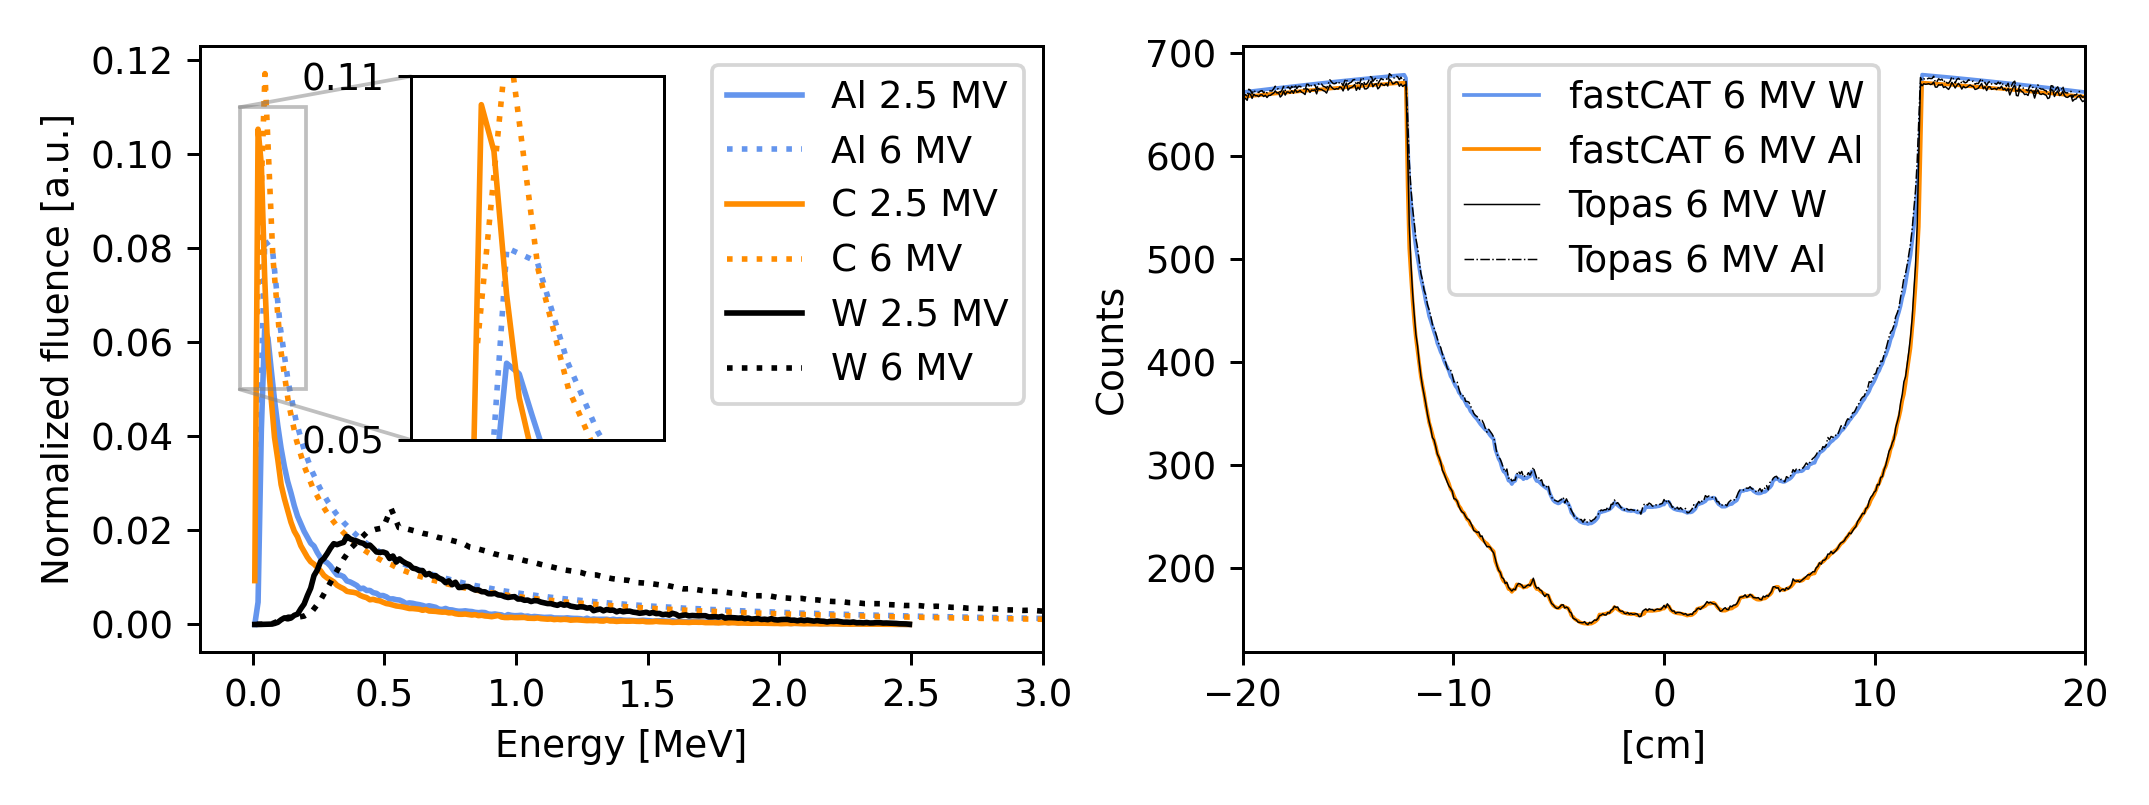

In [94]:
# plt.figure()
# plt.plot(-np.log(mc_noise/flood_summed2))

# plt.figure(dpi=300,figsize=[8,4])
# plt.subplot(121)

files = glob.glob('../xpecgen/data/MV_spectra/*.txt')

fig,ax = plt.subplots(1,2,figsize=[8,3],dpi=300)
names = []

fmt_spec = ['-', ':', '-', ':','-', ':', '-', ':']
colors = ['cornflowerblue','cornflowerblue','darkorange','darkorange','k','k',]

ax2 = ax[0].inset_axes([0.25, 0.35, 0.3, 0.6])
# axin2 = ax.inset_axes(
#         [-0.1, 0.04, 0.4, 0.08], transform=ax.transData)
# axin2.set_xticks([])
# axin2.set_yticks([])

for jj,file in enumerate(sorted(files)):
    
    fluence = []
    energies = []
    
    names.append(file.split('_'))

    with open(file) as f:

        for line in f:
            energies.append(float(line.split()[0]))
            fluence.append(float(line.split()[1]))

    fluence /= np.sum(fluence)
    
    ax[0].plot(energies,fluence,fmt_spec[jj],color=colors[jj])
    ax2.plot(energies,fluence,fmt_spec[jj],color=colors[jj])


    fluence_str = [str(fluenc) for fluenc in fluence]
    energies = [str(energy) for energy in energies]
    with open(file.split('.txt')[0] + 'topas','w') as out:
        out.write(file + '\n \n')
        out.write('dv:So/Example/BeamEnergySpectrumValues = ' + str(len(energies)) +' ' + ' '.join(energies) + '\n')
        out.write('uv:So/Example/BeamEnergySpectrumWeights = ' + str(len(energies)) + ' ' + ' '.join(fluence_str) + '\n \n')
        
labels = []

for ii in range(len(names)):
    
    labels.append(names[ii][1].split('/')[1] + ' 6 MV' if ii % 2 == 1 else names[ii][1].split('/')[1] + ' 2.5 MV')
    
ax[0].legend(labels)
ax[0].set_xlim([-0.2,3])
ax[0].set_xlabel('Energy [MeV]')
ax[0].set_ylabel('Normalized fluence [a.u.]')


ax2.set_xlim([-0.05,0.2])
ax2.set_ylim([0.05,0.11])
ax2.set_xticks([])
ax2.set_yticks([0.05,0.11])

ax[0].indicate_inset_zoom(ax2)

# plt.subplot(122)
# plt.plot(2*mc_noise)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
ax[1].plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
ax[1].plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')

# plt.plot(fc_prime_2 + 3*mc_scatter - 2*coh_scatter,'r',linewidth= 0.7)
# plt.plot(fc_prime_2)
# plt.plot(flood_summed2)
ax[1].plot(dist,real_spec,'k-',linewidth = 0.4)
ax[1].plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
ax[1].set_xlim([-20,20])
# plt.plot(dist,real_spec_water_2,'k--',linewidth = 0.7)
# plt.plot(real_spec_water_3*2,'k--',linewidth = 0.7)

ax[1].legend(['fastCAT 6 MV W','fastCAT 6 MV Al','Topas 6 MV W','Topas 6 MV Al'])
ax[1].set_xlabel('[cm]')
ax[1].set_ylabel('Counts')
plt.tight_layout()
# plt.plot(real_spec_water,'k',linewidth= 0.7)
# plt.plot(fc_prime_2 + 2*mc_scatter_e,'r')
# plt.plot(2*mc_noise,'g')
# plt.plot(fc_prime_2,'.')

In [95]:
plt.savefig('/home/xcite/fastcat_paper/figures/one_slice_comparison.pdf')